In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import histlite as hl
import csky as cy
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats
#making healpy maps
import h5py as h5
import healpy as hp
import os

In [95]:
#import setup
import chime_localizations as loc

import imp
imp.reload(setup)

<module 'setup' from '/home/jthwaites/FRB/setup.py'>

In [132]:
mpl.rcParams['font.size'] = 20
ana=cy.CONF['ana']

seed=8
new_nside=512

In [133]:
frbs=setup.load_frbs(spatial_priors=True)
#spatial prior: use FRB20190416A, dec=33.3
wn=np.where(frbs['src']=='FRB20190416A')
wn=wn[0][0] #want only one of the bursts

frb_probs, msk=loc.make_healpix_map('FRB20190416A', new_nside=new_nside, max_cl=0.9997)

sum of map probabilities: 1.00000


In [134]:
src=setup.sources(84600., frbs['mjd'].values[wn], frbs['ra_deg'].values[wn], 
                  frbs['dec_deg'].values[wn])

##sp_tr used for getting llh prior, injecting events
sp_tr = cy.get_spatial_prior_trial_runner(src_tr=src, 
                        llh_priors=frb_probs, get_pixmask=True)

In [ ]:
"""Checking the max penalties by looking at the priors
from csky/trial.py at line 1111

llh_prior_term = []
p=frb_probs

pt = np.where(p > 0, p, 1e-10 * np.min(p[p>0]))
pt = pt / np.sum(pt) /512
pt = np.log(pt)
pt = pt - np.max(pt)
llh_prior_term.append(pt)"""
#pt
#w=np.where(llh_p[0]>0.)[0]
#[llh_p[0][i] for i in w]

In [135]:
##inj signal w sp_tr
nsig=1
sig_trial= sp_tr.get_one_trial(nsig,seed=seed, poisson=True)

##check this fix again, seems ok with utils.py line 286
sig_trial.evss[0][1]['energy']=10**(sig_trial.evss[0][1]['log10energy'])
for i in range(len(sig_trial.evss[0][1])):
    print('ra=%.2f, dec=%.2f'
          %(np.degrees(sig_trial.evss[0][1]['ra'][i]),
            np.degrees(sig_trial.evss[0][1]['dec'][i])))

ra=148.07, dec=33.55
ra=146.94, dec=33.50
ra=146.51, dec=33.36
ra=146.83, dec=33.30


In [136]:
## scan sky, w/in 99.97% CL only - pixmask call
sstr = cy.get_sky_scan_trial_runner(ana=ana, nside=new_nside, 
            src_kw={'mjd':src['mjd'], 't_100':src['t_100'], 'sigma_t':0.}, 
            pixmask=msk)

#%time scan = sstr.get_one_scan(seed = seed, mp_cpus=15, logging=True)

##if signal trial: 
%time scan = sstr.get_one_scan_from_trial(sig_trial, seed = seed, mp_cpus=15, logging=True)

Scanning 226 locations using 15 cores:
        226/226 coordinates complete.   
CPU times: user 86.2 ms, sys: 849 ms, total: 936 ms
Wall time: 2.93 s


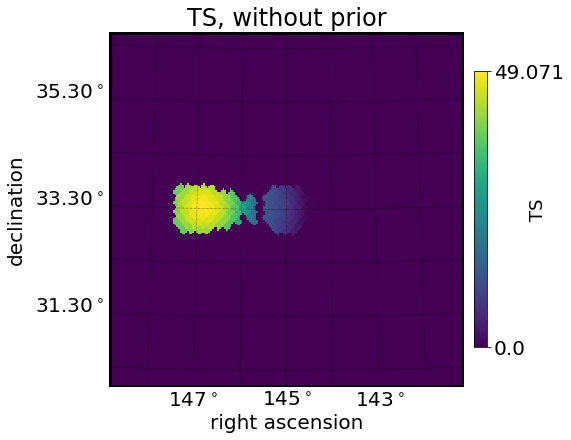

In [137]:
setup.plot_zoom(scan[1], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, without prior', 
                reso=2., col_label=r"TS", cmap='viridis')

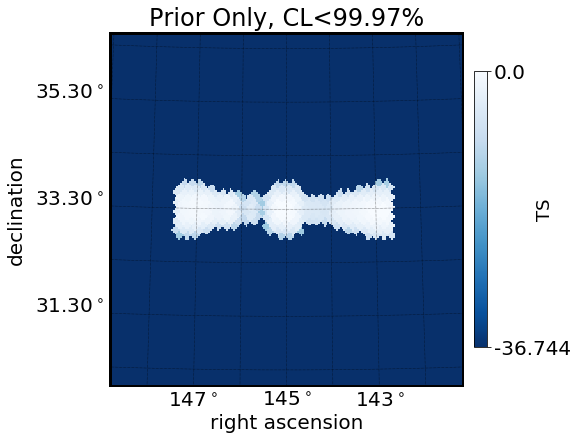

In [138]:
setup.plot_zoom(sp_tr.llh_prior_term[0], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='Prior Only, CL<99.97%',
                reso=2., col_label=r"TS", cmap='Blues')

In [116]:
#make ts_with_prior >=0
ts_with_prior=np.zeros(len(scan[1]))
w=np.where(scan[1]>0.)[0]
for i in w:
    pixel_ts=scan[1][i] + sp_tr.llh_prior_term[0][i]
    ts_with_prior[i]=max([pixel_ts,0])
    
#ts_with_prior = scan[1] + sp_tr.llh_prior_term[0]

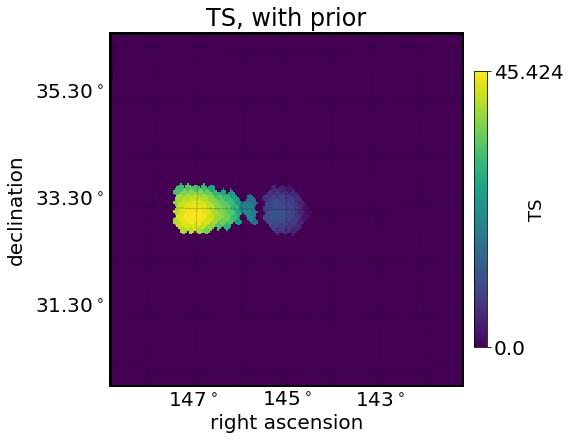

In [117]:
#ts_range=[min(sp_tr.llh_prior_term[0]),max(scan[1])]
setup.plot_zoom(ts_with_prior, src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, with prior', 
                reso=2, col_label=r"TS", cmap='viridis')